In [54]:
import numpy as np
from tqdm import tqdm
import cv2
from zipfile import ZipFile
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from torchvision import transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import json



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ml_exercise_therapanacea.zip to ml_exercise_therapanacea.zip


In [ ]:
file_name = "ml_exercise_therapanacea.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

In [22]:
y=[]
os.chdir('/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea')
with open('label_train.txt', 'r') as f:
    y = [int(line.strip()) for line in f.readlines()]
print(f"Total: {len(y)}, Distribution: {np.bincount(y)}")
X=[]
os.chdir('train_img')
def numerical_sort(value):
    # extrait les nombres dans le nom du fichier
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else 0

files = sorted(os.listdir(), key=numerical_sort)

Total: 100000, Distribution: [12102 87898]


In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(1, 9, i+1)
    image_index = i*20
    plt.imshow(X[image_index].astype('uint8'))
    plt.axis('off')
    plt.title(f'Photo #{image_index}', fontsize=10)
plt.show()

In [53]:
# Échantillonnage sur les indices seulement
sample_size = 10000
_, sample_indices = train_test_split(
    range(len(y)),
    test_size=sample_size,
    stratify=y,
    random_state=42
)

y = np.array(y)
sample_indices = np.array(sample_indices)
sample_labels = y[sample_indices]
print(f"Échantillon: {len(sample_labels)}")

# Split train/val/test : 60/20/20
train_indices_local, temp_indices_local = train_test_split(
    range(len(sample_labels)),
    test_size=0.4,  # 40% pour val+test
    stratify=sample_labels,
    random_state=42
)

val_indices_local, test_indices_local = train_test_split(
    temp_indices_local,
    test_size=0.5,  # 50% des 40% = 20% du total
    stratify=sample_labels[temp_indices_local],
    random_state=42
)

train_indices_local = np.array(train_indices_local)
val_indices_local = np.array(val_indices_local)
test_indices_local = np.array(test_indices_local)

# Créer les labels
y_train = sample_labels[train_indices_local]
y_val = sample_labels[val_indices_local]
y_test = sample_labels[test_indices_local]

# Créer les vrais indices pour charger les images
train_sample_indices = sample_indices[train_indices_local]
val_sample_indices = sample_indices[val_indices_local]
test_sample_indices = sample_indices[test_indices_local]

print(f"Train: {len(y_train)} ({len(y_train)/len(sample_labels)*100:.1f}%)")
print(f"Val: {len(y_val)} ({len(y_val)/len(sample_labels)*100:.1f}%)")
print(f"Test: {len(y_test)} ({len(y_test)/len(sample_labels)*100:.1f}%)")

# ===== AUGMENTATION DE DONNÉES AVEC TENSORFLOW =====

def augment_training_data_tf(X_train, y_train, augment_factor=2):
    """Augmente les données d'entraînement avec TensorFlow"""
    
    # Générateur d'augmentation TensorFlow pour accessoires
    datagen = ImageDataGenerator(
        rotation_range=5,               # Rotations très légères
        width_shift_range=0.05,         # Translations légères
        height_shift_range=0.05,
        zoom_range=0.05,                # Zoom léger
        horizontal_flip=True,           # Flip horizontal OK
        brightness_range=[0.8, 1.2],    # Variations d'éclairage
        fill_mode='nearest'
    )
    
    # Générateur pour focus sur partie supérieure (sans contrast_range)
    upper_datagen = ImageDataGenerator(
        brightness_range=[0.7, 1.3],
        rotation_range=3,
        zoom_range=0.1,
        fill_mode='nearest'
    )
    
    X_augmented = []
    y_augmented = []
    
    print("Augmentation des données d'entraînement avec TensorFlow...")
    
    for i, (img, label) in enumerate(tqdm(zip(X_train, y_train), total=len(X_train))):
        
        # Garder l'original
        X_augmented.append(img)
        y_augmented.append(label)
        
        # Augmentation plus agressive pour classe 0 (avec accessoires)
        if label == 0:
            num_augmentations = augment_factor * 2  # Plus d'augmentations pour classe 0
        else:
            num_augmentations = augment_factor
        
        # Créer des versions augmentées
        for aug_idx in range(num_augmentations):
            try:
                # Ajouter dimension batch pour TensorFlow
                img_batch = np.expand_dims(img, axis=0)
                
                # Augmentation focus sur partie supérieure (30% du temps)
                if random.random() < 0.3:
                    # Crop partie supérieure puis redimensionne
                    h, w = img.shape[:2]
                    cropped = img[:h//2, :, :]  # Garde la moitié supérieure
                    cropped_resized = cv2.resize(cropped, (224, 224))
                    
                    # Appliquer augmentation sur le crop
                    aug_iter = upper_datagen.flow(np.expand_dims(cropped_resized, axis=0), 
                                                 batch_size=1)
                    augmented_batch = next(aug_iter)
                    augmented_img = augmented_batch[0].astype(np.uint8)
                else:
                    # Augmentation normale
                    aug_iter = datagen.flow(img_batch, batch_size=1)
                    augmented_batch = next(aug_iter)
                    augmented_img = augmented_batch[0].astype(np.uint8)
                
                X_augmented.append(augmented_img)
                y_augmented.append(label)
                
            except Exception as e:
                # En cas d'erreur, dupliquer l'original
                X_augmented.append(img)
                y_augmented.append(label)
    
    return np.array(X_augmented), np.array(y_augmented)

# Charger les données d'entraînement originales (224x224 pour MobileNet)
print("\nChargement des données d'entraînement...")
X_train_original = []
for idx in tqdm(train_sample_indices, desc="Chargement train"):
    img_path = f'/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/train_img/{files[idx]}'
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # 224x224 pour MobileNet
        X_train_original.append(img)

X_train_original = np.array(X_train_original)

# Augmenter les données
print(f"\nDistribution avant augmentation:")
print(f"Classe 0: {np.sum(y_train == 0)}, Classe 1: {np.sum(y_train == 1)}")

X_train_augmented, y_train_augmented = augment_training_data_tf(X_train_original, y_train, augment_factor=2)

print(f"\nDistribution après augmentation:")
print(f"Classe 0: {np.sum(y_train_augmented == 0)}, Classe 1: {np.sum(y_train_augmented == 1)}")
print(f"Total images train: {len(X_train_augmented)} (vs {len(X_train_original)} original)")

# Charger validation et test (sans augmentation, 224x224)
print("\nChargement validation et test...")
X_val = []
for idx in tqdm(val_sample_indices, desc="Chargement val"):
    img_path = f'/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/train_img/{files[idx]}'
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # 224x224 pour MobileNet
        X_val.append(img)

X_test = []
for idx in tqdm(test_sample_indices, desc="Chargement test"):
    img_path = f'/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/train_img/{files[idx]}'
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # 224x224 pour MobileNet
        X_test.append(img)

X_val = np.array(X_val)
X_test = np.array(X_test)

print(f"Données finales:")
print(f"Train: {X_train_augmented.shape} (avec augmentation)")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Vérifier les dimensions
print(f"\n✅ Toutes les images sont en 224x224 pour MobileNet")
print(f"Train shape: {X_train_augmented.shape}")  # Should be (N, 224, 224, 3)
print(f"Val shape: {X_val.shape}")                # Should be (N, 224, 224, 3)
print(f"Test shape: {X_test.shape}")              # Should be (N, 224, 224, 3)

Échantillon: 10000
Train: 6000 (60.0%)
Val: 2000 (20.0%)
Test: 2000 (20.0%)

Chargement des données d'entraînement...


Chargement train: 100%|██████████| 6000/6000 [00:02<00:00, 2287.88it/s]



Distribution avant augmentation:
Classe 0: 726, Classe 1: 5274
Augmentation des données d'entraînement avec TensorFlow...


100%|██████████| 6000/6000 [01:24<00:00, 71.24it/s]



Distribution après augmentation:
Classe 0: 3630, Classe 1: 15822
Total images train: 19452 (vs 6000 original)

Chargement validation et test...


Chargement test: 100%|██████████| 2000/2000 [00:00<00:00, 2948.10it/s]


Données finales:
Train: (19452, 224, 224, 3) (avec augmentation)
Val: (2000, 224, 224, 3)
Test: (2000, 224, 224, 3)

✅ Toutes les images sont en 224x224 pour MobileNet
Train shape: (19452, 224, 224, 3)
Val shape: (2000, 224, 224, 3)
Test shape: (2000, 224, 224, 3)


In [6]:
# Maintenant vos images sont déjà en 224x224
img_rows, img_cols = 224, 224

# Load MobileNetV2
mobilenet = MobileNetV2(weights='imagenet',
                       include_top=False,
                       input_shape=(img_rows, img_cols, 3))
# Freeze the layers
for layer in mobilenet.layers:
    layer.trainable = False

In [7]:
def lw(bottom_model, num_classes=None):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)  # 1 sortie pour binaire
    return top_model

In [ ]:
num_classes = 2

FC_Head = lw(mobilenet)
model = Model(inputs = mobilenet.input, outputs = FC_Head)
print(model.summary())

In [9]:
# Au lieu de class_weight_dict calculé automatiquement
class_weight_dict = {0: 15.0, 1: 1.0}  # Beaucoup plus agressif !

# Ou calculer manuellement
total = len(y_train)
count_0 = np.sum(y_train == 0)
count_1 = np.sum(y_train == 1)

# Formule plus agressive
weight_0 = (total / count_0) * 2  # Multiplier par 2 ou 3
weight_1 = total / count_1

class_weight_dict = {0: weight_0, 1: weight_1}
print(f"Nouveaux poids: {class_weight_dict}")

Nouveaux poids: {0: np.float64(16.52892561983471), 1: np.float64(1.1376564277588168)}


In [10]:
# Compile the model with an optimizer and loss function
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
# from tensorflow.keras.optimizers import Adam
# # Learning rate beaucoup plus bas quand on dégèle des couches
# model.compile(optimizer=Adam(learning_rate=0.00001),  # Très bas !
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

#loss='binary_crossentropy',

🎯 CONFIGURATION:
   Données: AUGMENTÉES
   Métrique complémentaire: OUI
   Poids: HTER=0.8, F1=0.2
   EarlyStopping patience: 10
   Min delta amélioration: 0.0010 (0.1%)
✅ Modèle existant trouvé, chargement...
📂 Modèle chargé depuis: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras
🔄 L'entraînement va continuer depuis ce point
Learning rate du modèle chargé: 1.00e-05
🔄 Réinitialisation du learning rate à: 1.00e-05

Création des générateurs...
Utilisation des données augmentées...
Distribution par batch: 16 classe 0 + 16 classe 1
Disponible: 3630 classe 0, 15822 classe 1
Distribution par batch: 3 classe 0 + 29 classe 1
Disponible: 242 classe 0, 1758 classe 1
Distribution par batch: 3 classe 0 + 29 classe 1
Disponible: 242 classe 0, 1758 classe 1

🔧 Configuration des callbacks...
🎯 Configuration LearningRateTracker:
   Seuil fixe: 0.6
   Métrique complémentaire: OUI
   Min delta pour amélioration: 0.0010
   Poids complémentaire: 0.2
✅ Callbacks c

/Users/macbookair/Library/Python/3.11/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Validation accuracy actuelle: 0.8537
Validation loss actuelle: 0.3163

🚀 Début/Reprise de l'entraînement...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8495 - loss: 0.3163✅ Amélioration significative Score Combiné: inf → 0.1395 (Δ=inf)
   HTER: 0.1414 | F1: 0.8682 | Balanced Acc: 0.8586
🏆 MEILLEURS HTER par seuil: 0.2:0.2055 0.3:0.1800 0.4:0.1531 0.5:0.1563 0.6:0.1414★ 0.7:0.1586 0.8:0.1706 
💾 Epoch 1: Score Combiné improved significantly from inf to 0.1395 (Δ=inf)
💾 Saving model...
💾 Sauvegarde avec seuil: 0.60, HTER: 0.1414
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8492 - loss: 0.3168 - val_accuracy: 0.8637 - val_loss: 0.2983 - lr: 1.0000e-05 - val_hter: 0.1414 - val_f1: 0.8682 - val_balanced_acc: 0.8586 - val_combined_score: 0.1395
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8776 - loss: 0.3068✅ Amélioration significative Score Combiné: 0.1395 → 0.1380 (Δ=0.0015)
   HTER: 0.1400 | F1: 0.8701 | Balanced Acc: 0.8600
🏆 MEILLEURS HT

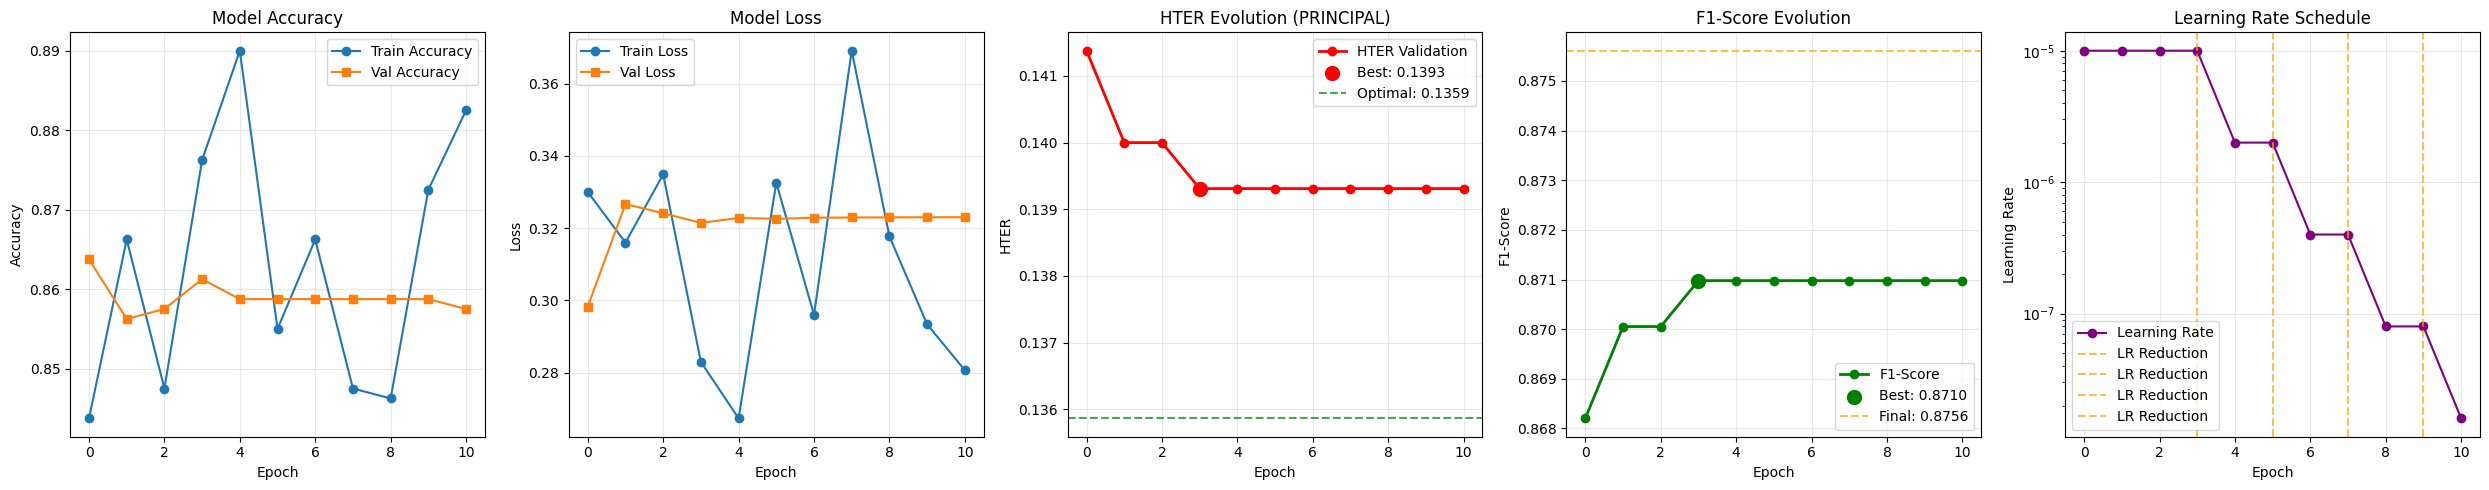

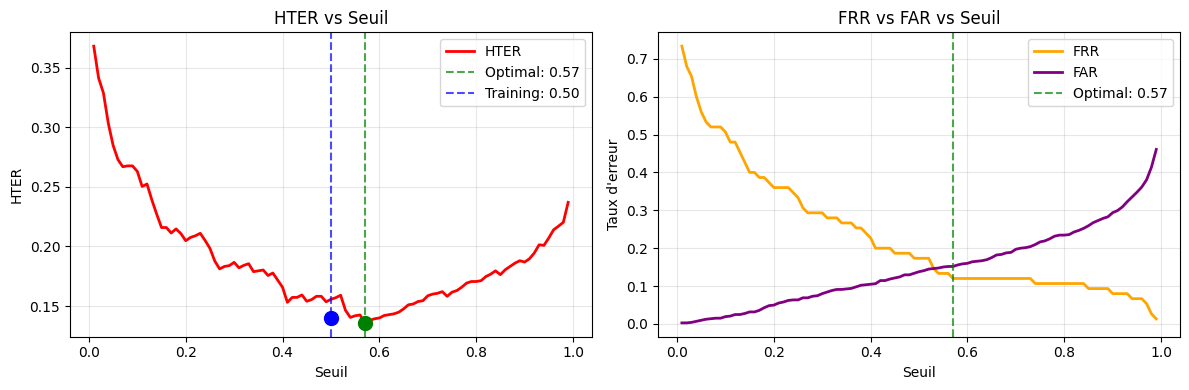


📊 RÉSUMÉ DE CETTE SESSION:
Mode d'entraînement: AUGMENTÉ
Optimisation: HTER + F1
Poids: HTER=0.8, F1=0.2
Seuil d'entraînement: 0.5
Seuil optimal final: 0.57
Min delta: 0.0010
Epochs entraînés: 11
EarlyStopping: activé epoch 11
Meilleure val_accuracy: 0.8637 (epoch 1)
Learning rate: 1.00e-05 → 1.60e-08
Meilleur HTER d'entraînement: 0.1400
Meilleur HTER optimal: 0.1359
Meilleur score combiné: 0.1380
Learning rate réduit aux epochs: [4, 6, 8, 10]

💾 MÉTRIQUES COMPLÈTES SAUVEGARDÉES:
   NON-AUGMENTÉ:
     - Seuil entraînement: 0.50 (HTER: 0.1444)
     - Seuil optimal: 0.58 (HTER: 0.1409)
     - Amélioration: 0.0034
   AUGMENTÉ: ← ACTUEL
     - Seuil entraînement: 0.50 (HTER: 0.1400)
     - Seuil optimal: 0.57 (HTER: 0.1359)
     - Amélioration: 0.0041

💾 Modèle sauvegardé à: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras
🔄 Vous pouvez relancer cette cellule pour continuer l'entraînement
🔧 Configuration modifiable:
   - USE_AUGMENTED_DATA: donnée

In [ ]:
import json
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
from datetime import datetime

class StratifiedGeneratorAugmented(Sequence):
    def __init__(self, X_data, y_data, batch_size=32, class_0_ratio=0.5, fixed_seed=None):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.class_0_ratio = class_0_ratio
        self.fixed_seed = fixed_seed  # NOUVEAU : pour reproductibilité
        
        # Séparer les indices par classe
        self.class_0_indices = np.where(y_data == 0)[0]
        self.class_1_indices = np.where(y_data == 1)[0]
        
        # Calculer combien d'images de chaque classe par batch
        self.n_class_0_per_batch = int(batch_size * class_0_ratio)
        self.n_class_1_per_batch = batch_size - self.n_class_0_per_batch
        
        print(f"Distribution par batch: {self.n_class_0_per_batch} classe 0 + {self.n_class_1_per_batch} classe 1")
        print(f"Disponible: {len(self.class_0_indices)} classe 0, {len(self.class_1_indices)} classe 1")
        
        self._shuffle_indices()
        
    def _shuffle_indices(self):
        # NOUVEAU : utiliser une seed fixe pour la validation
        if self.fixed_seed is not None:
            np.random.seed(self.fixed_seed)
            
        needed_0 = self.n_class_0_per_batch * 50
        needed_1 = self.n_class_1_per_batch * 50
        
        repeat_0 = max(1, needed_0 // len(self.class_0_indices) + 1)
        repeat_1 = max(1, needed_1 // len(self.class_1_indices) + 1)
        
        self.shuffled_0 = np.tile(self.class_0_indices, repeat_0)
        self.shuffled_1 = np.tile(self.class_1_indices, repeat_1)
        
        np.random.shuffle(self.shuffled_0)
        np.random.shuffle(self.shuffled_1)
        
        self.idx_0 = 0
        self.idx_1 = 0
        
        # Reset seed pour éviter d'affecter d'autres random
        if self.fixed_seed is not None:
            np.random.seed(None)
        
    def __len__(self):
        return 25
    
    def __getitem__(self, idx):
        if (self.idx_0 + self.n_class_0_per_batch >= len(self.shuffled_0) or 
            self.idx_1 + self.n_class_1_per_batch >= len(self.shuffled_1)):
            self._shuffle_indices()
        
        batch_0_indices = self.shuffled_0[self.idx_0:self.idx_0 + self.n_class_0_per_batch]
        batch_1_indices = self.shuffled_1[self.idx_1:self.idx_1 + self.n_class_1_per_batch]
        
        self.idx_0 += self.n_class_0_per_batch
        self.idx_1 += self.n_class_1_per_batch
        
        batch_indices = np.concatenate([batch_0_indices, batch_1_indices])
        np.random.shuffle(batch_indices)
        
        batch_x = []
        batch_y = []
        
        for i in batch_indices:
            img = self.X_data[i].astype(np.float32)
            img = preprocess_input(img)
            batch_x.append(img)
            batch_y.append(self.y_data[i])
        
        return np.array(batch_x), np.array(batch_y)

# ===== CALLBACK POUR TRAQUER LE LEARNING RATE AVEC ADAPTATION =====
class LearningRateTracker(tf.keras.callbacks.Callback):
    def __init__(self, val_data, hter_patience=2, lr_reduction_factor=0.2, min_lr=1e-8, 
                 use_complementary_metric=True, complementary_weight=0.2, min_delta=0.001):
        self.lr_history = []
        self.hter_history = []
        self.f1_history = []
        self.balanced_acc_history = []
        self.combined_score_history = []
        self.val_data = val_data
        self.hter_patience = hter_patience
        self.lr_reduction_factor = lr_reduction_factor
        self.min_lr = min_lr
        self.use_complementary_metric = use_complementary_metric
        self.complementary_weight = complementary_weight
        self.min_delta = min_delta  # NOUVEAU : minimum delta pour amélioration significative
        
        # Métriques globales
        self.best_hter_global = float('inf')
        self.best_combined_score_global = float('inf')
        self.best_threshold_global = None
        self.epochs_without_improvement = 0
        self.lr_reductions_occurred = []
        self.best_metrics_per_threshold = {}
        
        # Seuil fixe pour la cohérence (comme recommandé)
        self.fixed_threshold = 0.6
        
        # Seuils pour l'analyse (optionnel)
        self.thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        for threshold in self.thresholds:
            self.best_metrics_per_threshold[threshold] = {
                'best_hter': float('inf'),
                'best_combined': float('inf'),
                'best_epoch': 0,
                'min_hter': float('inf'),
                'max_hter': 0
            }
        
        print(f"🎯 Configuration LearningRateTracker:")
        print(f"   Seuil fixe: {self.fixed_threshold}")
        print(f"   Métrique complémentaire: {'OUI' if use_complementary_metric else 'NON'}")
        print(f"   Min delta pour amélioration: {self.min_delta:.4f}")
        if use_complementary_metric:
            print(f"   Poids complémentaire: {complementary_weight}")
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # Récupérer le learning rate actuel
        lr = float(self.model.optimizer.learning_rate)
        self.lr_history.append(lr)
        logs['lr'] = lr
        
        # Calculer les métriques avec seuil fixe
        current_hter, current_f1, current_balanced_acc, current_combined = self._calculate_fixed_threshold_metrics(epoch, logs)
        
        # Ajouter aux historiques
        self.hter_history.append(current_hter)
        self.f1_history.append(current_f1)
        self.balanced_acc_history.append(current_balanced_acc)
        self.combined_score_history.append(current_combined)
        
        # Choisir la métrique d'optimisation
        if self.use_complementary_metric:
            optimization_metric = current_combined
            best_global_metric = self.best_combined_score_global
            metric_name = "Score Combiné"
        else:
            optimization_metric = current_hter
            best_global_metric = self.best_hter_global
            metric_name = "HTER"
        
        # Vérifier si la métrique s'est améliorée DE MANIÈRE SIGNIFICATIVE
        improvement = best_global_metric - optimization_metric
        
        if improvement >= self.min_delta:  # NOUVEAU : amélioration significative seulement
            if self.use_complementary_metric:
                self.best_combined_score_global = optimization_metric
            self.best_hter_global = current_hter
            self.best_threshold_global = self.fixed_threshold
            self.epochs_without_improvement = 0
            
            print(f"✅ Amélioration significative {metric_name}: {best_global_metric:.4f} → {optimization_metric:.4f} (Δ={improvement:.4f})")
            print(f"   HTER: {current_hter:.4f} | F1: {current_f1:.4f} | Balanced Acc: {current_balanced_acc:.4f}")
            
            # Sauvegarder le meilleur seuil dans les métadonnées du modèle
            setattr(self.model, 'best_threshold', self.best_threshold_global)
            setattr(self.model, 'best_hter', self.best_hter_global)
                
        else:
            # Amélioration trop faible ou pas d'amélioration
            if optimization_metric < best_global_metric:
                print(f"🔸 Amélioration trop faible {metric_name}: {best_global_metric:.4f} → {optimization_metric:.4f} (Δ={improvement:.4f} < {self.min_delta:.4f})")
            else:
                print(f"❌ Pas d'amélioration {metric_name}: {optimization_metric:.4f} vs {best_global_metric:.4f}")
            
            self.epochs_without_improvement += 1
        
        # Vérifier si on a atteint le LR minimum
        if lr <= self.min_lr:
            print(f"\n🛑 Learning rate minimum atteint ({self.min_lr:.2e}) - Arrêt de l'entraînement")
            self.model.stop_training = True
            return
        
        # Réduire LR si pas d'amélioration pendant hter_patience epochs
        if self.epochs_without_improvement >= self.hter_patience:
            new_lr = lr * self.lr_reduction_factor
            
            if new_lr >= self.min_lr:
                print(f"\n📉 Pas d'amélioration {metric_name} depuis {self.hter_patience} epochs")
                print(f"Réduction du learning rate: {lr:.2e} → {new_lr:.2e}")
                self.model.optimizer.learning_rate.assign(new_lr)
                self.epochs_without_improvement = 0
                self.lr_reductions_occurred.append(epoch + 1)
                logs['lr'] = new_lr
            else:
                print(f"\n🛑 Learning rate minimum atteint ({self.min_lr:.2e}) - Arrêt de l'entraînement")
                self.model.stop_training = True
        
        # Calcul des métriques pour tous les seuils (analyse)
        self._calculate_all_thresholds_metrics(epoch, logs)
    
    def _calculate_fixed_threshold_metrics(self, epoch, logs=None):
        """Calcule les métriques avec le seuil fixe pour la décision"""
        # Reset du générateur pour garantir la reproductibilité
        if hasattr(self.val_data, 'fixed_seed'):
            self.val_data._shuffle_indices()
        
        # Récupérer les prédictions et vraies étiquettes
        y_pred_proba = []
        y_true = []
        
        for i in range(len(self.val_data)):
            batch_x, batch_y = self.val_data[i]
            batch_pred = self.model.predict(batch_x, verbose=0)
            y_pred_proba.extend(batch_pred.flatten())
            y_true.extend(batch_y.flatten())
        
        y_pred_proba = np.array(y_pred_proba)
        y_true = np.array(y_true)
        
        # Classification avec seuil fixe
        y_pred_binary = (y_pred_proba >= self.fixed_threshold).astype(int)
        
        # Calcul des métriques
        cm = confusion_matrix(y_true, y_pred_binary)
        
        # HTER
        frr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        far = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        hter = (far + frr) / 2
        
        # Métriques complémentaires
        f1 = f1_score(y_true, y_pred_binary, average='weighted')
        balanced_acc = balanced_accuracy_score(y_true, y_pred_binary)
        
        # Score combiné (HTER reste prioritaire)
        if self.use_complementary_metric:
            # Inverser F1 et balanced_acc pour que "plus bas = mieux" comme HTER
            combined_score = (1 - self.complementary_weight) * hter + self.complementary_weight * (1 - f1)
        else:
            combined_score = hter
        
        # Stocker pour les autres callbacks
        logs = logs or {}
        logs['val_hter'] = hter
        logs['val_f1'] = f1
        logs['val_balanced_acc'] = balanced_acc
        logs['val_combined_score'] = combined_score
        
        return hter, f1, balanced_acc, combined_score
    
    def _calculate_all_thresholds_metrics(self, epoch, logs=None):
        """Calcule les métriques pour tous les seuils (analyse seulement)"""
        # Reset du générateur
        if hasattr(self.val_data, 'fixed_seed'):
            self.val_data._shuffle_indices()
        
        # Récupérer les prédictions
        y_pred_proba = []
        y_true = []
        
        for i in range(len(self.val_data)):
            batch_x, batch_y = self.val_data[i]
            batch_pred = self.model.predict(batch_x, verbose=0)
            y_pred_proba.extend(batch_pred.flatten())
            y_true.extend(batch_y.flatten())
        
        y_pred_proba = np.array(y_pred_proba)
        y_true = np.array(y_true)
        
        # Analyser tous les seuils
        for threshold in self.thresholds:
            y_pred_binary = (y_pred_proba >= threshold).astype(int)
            
            # Matrice de confusion
            cm = confusion_matrix(y_true, y_pred_binary)
            
            # Calcul HTER
            frr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            far = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
            hter = (far + frr) / 2
            
            # Métrique complémentaire
            f1 = f1_score(y_true, y_pred_binary, average='weighted')
            combined = (1 - self.complementary_weight) * hter + self.complementary_weight * (1 - f1)
            
            # Mettre à jour les meilleures métriques
            if hter < self.best_metrics_per_threshold[threshold]['best_hter']:
                self.best_metrics_per_threshold[threshold]['best_hter'] = hter
                self.best_metrics_per_threshold[threshold]['best_epoch'] = epoch + 1
            
            if combined < self.best_metrics_per_threshold[threshold]['best_combined']:
                self.best_metrics_per_threshold[threshold]['best_combined'] = combined
            
            # Mettre à jour min/max HTER
            if hter < self.best_metrics_per_threshold[threshold]['min_hter']:
                self.best_metrics_per_threshold[threshold]['min_hter'] = hter
            if hter > self.best_metrics_per_threshold[threshold]['max_hter']:
                self.best_metrics_per_threshold[threshold]['max_hter'] = hter
        
        # Afficher les meilleures métriques HTER (version compacte)
        print(f"🏆 MEILLEURS HTER par seuil: ", end="")
        best_overall = min(self.best_metrics_per_threshold.items(), key=lambda x: x[1]['best_hter'])
        for threshold in self.thresholds:
            best = self.best_metrics_per_threshold[threshold]
            marker = "★" if threshold == best_overall[0] else ""
            print(f"{threshold:.1f}:{best['best_hter']:.4f}{marker} ", end="")
        print()

# ===== CALLBACK PERSONNALISÉ POUR SAUVEGARDER LE MEILLEUR MODÈLE =====
class HTERModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, use_complementary_metric=True, min_delta=0.001, verbose=1):
        super().__init__()
        self.filepath = filepath
        self.use_complementary_metric = use_complementary_metric
        self.min_delta = min_delta  # NOUVEAU : minimum delta pour sauvegarde
        self.verbose = verbose
        self.best_hter = float('inf')
        self.best_combined = float('inf')
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_hter = logs.get('val_hter', float('inf'))
        current_combined = logs.get('val_combined_score', float('inf'))
        
        if self.use_complementary_metric:
            current_metric = current_combined
            best_metric = self.best_combined
            metric_name = "Score Combiné"
        else:
            current_metric = current_hter
            best_metric = self.best_hter
            metric_name = "HTER"
        
        # Calculer l'amélioration
        improvement = best_metric - current_metric
        
        if improvement >= self.min_delta:  # NOUVEAU : amélioration significative seulement
            if self.verbose > 0:
                print(f"💾 Epoch {epoch + 1}: {metric_name} improved significantly from {best_metric:.4f} to {current_metric:.4f} (Δ={improvement:.4f})")
                print(f"💾 Saving model...")
            
            if self.use_complementary_metric:
                self.best_combined = current_metric
            self.best_hter = current_hter
            
            # Sauvegarder avec les métadonnées
            if hasattr(self.model, 'best_threshold'):
                if self.verbose > 0:
                    print(f"💾 Sauvegarde avec seuil: {self.model.best_threshold:.2f}, HTER: {current_hter:.4f}")
            self.model.save(self.filepath)
            
        else:
            if self.verbose > 0 and improvement > 0:
                print(f"🔸 Epoch {epoch + 1}: {metric_name} improved but not significantly (Δ={improvement:.4f} < {self.min_delta:.4f}) - No save")
            elif self.verbose > 0:
                print(f"❌ Epoch {epoch + 1}: {metric_name} did not improve ({current_metric:.4f} vs {best_metric:.4f}) - No save")

# ===== FONCTION POUR TROUVER LE SEUIL OPTIMAL FINAL =====
def find_optimal_threshold_final(model, val_gen, verbose=True):
    """Trouve le seuil optimal sur le modèle final avec grain fin"""
    
    if verbose:
        print("🔍 Recherche du seuil optimal final...")
    
    # Reset du générateur
    if hasattr(val_gen, 'fixed_seed'):
        val_gen._shuffle_indices()
    
    # Récupérer toutes les prédictions
    y_pred_proba = []
    y_true = []
    
    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        batch_pred = model.predict(batch_x, verbose=0)
        y_pred_proba.extend(batch_pred.flatten())
        y_true.extend(batch_y.flatten())
    
    y_pred_proba = np.array(y_pred_proba)
    y_true = np.array(y_true)
    
    # Tester des seuils avec grain fin
    thresholds = np.arange(0.01, 1.0, 0.01)  # 99 seuils
    best_hter = float('inf')
    best_threshold = 0.5
    results = []
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        
        # Matrice de confusion
        cm = confusion_matrix(y_true, y_pred_binary)
        
        # Calcul HTER
        frr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        far = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        hter = (far + frr) / 2
        
        results.append({
            'threshold': threshold,
            'hter': hter,
            'frr': frr,
            'far': far
        })
        
        if hter < best_hter:
            best_hter = hter
            best_threshold = threshold
    
    if verbose:
        print(f"🎯 Seuil optimal trouvé: {best_threshold:.2f} avec HTER: {best_hter:.4f}")
        
        # Afficher top 5
        sorted_results = sorted(results, key=lambda x: x['hter'])
        print(f"🏆 Top 5 meilleurs seuils:")
        for i, result in enumerate(sorted_results[:5]):
            star = "★" if result['threshold'] == best_threshold else " "
            print(f"{star} {i+1}. Seuil {result['threshold']:.2f}: HTER={result['hter']:.4f}, FRR={result['frr']:.4f}, FAR={result['far']:.4f}")
    
    return best_threshold, best_hter, results

# ===== FONCTION POUR SAUVEGARDER/CHARGER LES MÉTRIQUES =====
def save_comprehensive_metrics(training_threshold, training_hter, optimal_threshold, optimal_hter, 
                              use_augmented, filepath=None):
    """Sauvegarde les métriques complètes dans un fichier JSON"""
    
    # Chemin par défaut
    if filepath is None:
        filepath = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/comprehensive_metrics.json'
    
    try:
        # Charger les métriques existantes
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                data = json.load(f)
        else:
            data = {}
        
        # Mettre à jour les métriques appropriées
        key = "augmented" if use_augmented else "non_augmented"
        data[key] = {
            "training_threshold": float(training_threshold),
            "training_hter": float(training_hter),
            "optimal_threshold": float(optimal_threshold),
            "optimal_hter": float(optimal_hter),
            "improvement": float(training_hter - optimal_hter),
            "timestamp": str(datetime.now())
        }
        
        # Sauvegarder
        with open(filepath, 'w') as f:
            json.dump(data, f, indent=2)
        
        print(f"💾 Métriques complètes sauvegardées dans {filepath}:")
        print(f"   Mode: {key}")
        print(f"   Seuil d'entraînement: {training_threshold:.2f} (HTER: {training_hter:.4f})")
        print(f"   Seuil optimal: {optimal_threshold:.2f} (HTER: {optimal_hter:.4f})")
        print(f"   Amélioration: {training_hter - optimal_hter:.4f}")
        
    except Exception as e:
        print(f"⚠️ Erreur lors de la sauvegarde: {e}")

def load_comprehensive_metrics(filepath=None):
    """Charge les métriques complètes depuis un fichier JSON"""
    
    # Chemin par défaut
    if filepath is None:
        filepath = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/comprehensive_metrics.json'
    
    try:
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                data = json.load(f)
            return data
    except Exception as e:
        print(f"⚠️ Erreur lors du chargement: {e}")
    return {}

# ===== CONFIGURATION =====
USE_AUGMENTED_DATA = False
USE_COMPLEMENTARY_METRIC = True  # Utiliser F1 en complément de HTER
COMPLEMENTARY_WEIGHT = 0.2       # 20% pour F1, 80% pour HTER
EARLY_STOPPING_PATIENCE = 10     # Patience pour l'EarlyStopping
MIN_DELTA_IMPROVEMENT = 0.001    # NOUVEAU : minimum delta pour amélioration significative (0.1%)

print(f"🎯 CONFIGURATION:")
print(f"   Données: {'AUGMENTÉES' if USE_AUGMENTED_DATA else 'NON-AUGMENTÉES'}")
print(f"   Métrique complémentaire: {'OUI' if USE_COMPLEMENTARY_METRIC else 'NON'}")
if USE_COMPLEMENTARY_METRIC:
    print(f"   Poids: HTER={1-COMPLEMENTARY_WEIGHT:.1f}, F1={COMPLEMENTARY_WEIGHT:.1f}")
print(f"   EarlyStopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"   Min delta amélioration: {MIN_DELTA_IMPROVEMENT:.4f} ({MIN_DELTA_IMPROVEMENT*100:.1f}%)")

# ===== CONFIGURATION DES CHEMINS =====
if USE_AUGMENTED_DATA:
    model_path = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras'
else:
    model_path = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_no_augmented.keras'

# ===== VÉRIFICATION ET CHARGEMENT DU MODÈLE =====
INITIAL_LR_NEW_MODEL = 1e-3
INITIAL_LR_EXISTING_MODEL = 1e-5

if os.path.exists(model_path):
    print("✅ Modèle existant trouvé, chargement...")
    model = load_model(model_path)
    print(f"📂 Modèle chargé depuis: {model_path}")
    print("🔄 L'entraînement va continuer depuis ce point")
    
    current_lr = float(model.optimizer.learning_rate)
    print(f"Learning rate du modèle chargé: {current_lr:.2e}")
    
    print(f"🔄 Réinitialisation du learning rate à: {INITIAL_LR_EXISTING_MODEL:.2e}")
    model.optimizer.learning_rate.assign(INITIAL_LR_EXISTING_MODEL)
else:
    print("🆕 Aucun modèle sauvegardé trouvé")
    print("🚀 L'entraînement va commencer depuis zéro")
    
    print(f"🔄 Learning rate initial: {INITIAL_LR_NEW_MODEL:.2e}")
    model.optimizer.learning_rate.assign(INITIAL_LR_NEW_MODEL)

# ===== CRÉATION DES GÉNÉRATEURS =====
print("\nCréation des générateurs...")

if USE_AUGMENTED_DATA:
    print("Utilisation des données augmentées...")
    train_gen = StratifiedGeneratorAugmented(X_train_augmented, y_train_augmented, 
                                            batch_size=32, class_0_ratio=0.5)
else:
    print("Utilisation des données non-augmentées...")
    train_gen = StratifiedGeneratorAugmented(X_train_original, y_train, 
                                            batch_size=32, class_0_ratio=0.5)

val_class_0_ratio = np.sum(y_val == 0) / len(y_val)
val_gen = StratifiedGeneratorAugmented(X_val, y_val, 
                                      batch_size=32, class_0_ratio=val_class_0_ratio, 
                                      fixed_seed=42)

test_gen = StratifiedGeneratorAugmented(X_test, y_test, 
                                       batch_size=32, class_0_ratio=np.sum(y_test == 0) / len(y_test),
                                       fixed_seed=123)

# ===== CONFIGURATION DES CALLBACKS =====
print("\n🔧 Configuration des callbacks...")

# 1. LearningRateTracker (gestion HTER et LR)
lr_tracker = LearningRateTracker(
    val_gen, 
    hter_patience=2, 
    lr_reduction_factor=0.2, 
    min_lr=1e-8,
    use_complementary_metric=USE_COMPLEMENTARY_METRIC,
    complementary_weight=COMPLEMENTARY_WEIGHT,
    min_delta=MIN_DELTA_IMPROVEMENT  # NOUVEAU !
)

# 2. HTERModelCheckpoint (sauvegarde du meilleur modèle)
checkpoint = HTERModelCheckpoint(
    filepath=model_path, 
    use_complementary_metric=USE_COMPLEMENTARY_METRIC,
    min_delta=MIN_DELTA_IMPROVEMENT,  # NOUVEAU !
    verbose=1
)

# 3. EarlyStopping (sécurité anti-surentraînement)
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la loss de validation
    patience=EARLY_STOPPING_PATIENCE,  # Patience plus longue
    restore_best_weights=True,  # Restaure les meilleurs poids
    verbose=1,
    mode='min'
)

print("✅ Callbacks configurés:")
print(f"   - LearningRateTracker: patience={lr_tracker.hter_patience}, réduction={lr_tracker.lr_reduction_factor}, min_delta={lr_tracker.min_delta:.4f}")
print(f"   - HTERModelCheckpoint: métrique={'combinée' if USE_COMPLEMENTARY_METRIC else 'HTER seul'}, min_delta={MIN_DELTA_IMPROVEMENT:.4f}")
print(f"   - EarlyStopping: monitor=val_loss, patience={EARLY_STOPPING_PATIENCE}")

# ===== ÉVALUATION AVANT ENTRAÎNEMENT =====
print("\n📊 Évaluation du modèle actuel:")
initial_loss, initial_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation accuracy actuelle: {initial_acc:.4f}")
print(f"Validation loss actuelle: {initial_loss:.4f}")

# ===== ENTRAÎNEMENT =====
print("\n🚀 Début/Reprise de l'entraînement...")

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=1,
    callbacks=[lr_tracker, checkpoint, early_stopping]  # ORDRE IMPORTANT !
)

print("✅ Entraînement terminé !")

# ===== ANALYSE DU RÉSULTAT =====
print("\n🔍 Analyse de l'arrêt d'entraînement:")
if early_stopping.stopped_epoch > 0:
    print(f"🛑 EarlyStopping activé à l'epoch {early_stopping.stopped_epoch + 1}")
    print(f"   Raison: val_loss n'a pas diminué pendant {EARLY_STOPPING_PATIENCE} epochs")
else:
    print("✅ Entraînement terminé normalement (pas d'EarlyStopping)")

# ===== CHARGEMENT DU MEILLEUR MODÈLE =====
print("\n📂 Chargement du meilleur modèle sauvegardé...")
best_model = load_model(model_path)

# ===== RECHERCHE DU SEUIL OPTIMAL FINAL =====
print("\n🎯 RECHERCHE DU SEUIL OPTIMAL FINAL:")
optimal_threshold, optimal_hter, threshold_results = find_optimal_threshold_final(best_model, val_gen, verbose=True)

# ===== COMPARAISON SEUIL D'ENTRAÎNEMENT VS SEUIL OPTIMAL =====
training_threshold = 0.6  # Seuil fixe utilisé pendant l'entraînement
training_hter = lr_tracker.best_hter_global if hasattr(lr_tracker, 'best_hter_global') else float('inf')

print(f"\n📊 COMPARAISON SEUILS:")
print(f"   Seuil d'entraînement: {training_threshold:.2f} → HTER: {training_hter:.4f}")
print(f"   Seuil optimal: {optimal_threshold:.2f} → HTER: {optimal_hter:.4f}")
print(f"   Amélioration: {training_hter - optimal_hter:.4f} ({((training_hter - optimal_hter) / training_hter * 100):.1f}%)")

# ===== SAUVEGARDE DES MÉTRIQUES COMPLÈTES (UNIQUEMENT) =====
print("\n💾 SAUVEGARDE DES MÉTRIQUES COMPLÈTES...")
save_comprehensive_metrics(
    training_threshold=training_threshold,
    training_hter=training_hter,
    optimal_threshold=optimal_threshold,
    optimal_hter=optimal_hter,
    use_augmented=USE_AUGMENTED_DATA
)

# ===== ÉVALUATION FINALE AVEC SEUIL OPTIMAL =====
print(f"\n📊 ÉVALUATION FINALE avec seuil optimal {optimal_threshold:.2f}:")

# Reset du générateur de validation
val_gen._shuffle_indices()

# Prédictions
y_pred_proba_final = []
y_true_final = []

for i in range(len(val_gen)):
    batch_x, batch_y = val_gen[i]
    batch_pred = best_model.predict(batch_x, verbose=0)
    y_pred_proba_final.extend(batch_pred.flatten())
    y_true_final.extend(batch_y.flatten())

y_pred_proba_final = np.array(y_pred_proba_final)
y_true_final = np.array(y_true_final)

# Classification avec seuil optimal
y_pred_binary_final = (y_pred_proba_final >= optimal_threshold).astype(int)
cm_final = confusion_matrix(y_true_final, y_pred_binary_final)

# Calcul des métriques finales
frr_final = cm_final[0, 1] / (cm_final[0, 0] + cm_final[0, 1]) if (cm_final[0, 0] + cm_final[0, 1]) > 0 else 0
far_final = cm_final[1, 0] / (cm_final[1, 0] + cm_final[1, 1]) if (cm_final[1, 0] + cm_final[1, 1]) > 0 else 0
hter_final = (far_final + frr_final) / 2

f1_final = f1_score(y_true_final, y_pred_binary_final, average='weighted')
balanced_acc_final = balanced_accuracy_score(y_true_final, y_pred_binary_final)

tn, fp, fn, tp = cm_final.ravel()
precision_final = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_final = tp / (tp + fn) if (tp + fn) > 0 else 0
accuracy_final = (tp + tn) / (tp + tn + fp + fn)

print(f"🏆 RÉSULTATS FINAUX:")
print(f"   Critère principal - HTER: {hter_final:.4f}")
print(f"   Métriques complémentaires:")
print(f"     - F1-score: {f1_final:.4f}")
print(f"     - Balanced Accuracy: {balanced_acc_final:.4f}")
print(f"   Métriques détaillées:")
print(f"     - FRR (False Rejection): {frr_final:.4f}")
print(f"     - FAR (False Acceptance): {far_final:.4f}")
print(f"     - Précision: {precision_final:.4f}")
print(f"     - Rappel: {recall_final:.4f}")
print(f"     - Accuracy: {accuracy_final:.4f}")
print(f"   Matrice de confusion: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Vérification de cohérence
print(f"\n🔍 VÉRIFICATION:")
print(f"HTER optimal calculé: {optimal_hter:.4f}")
print(f"HTER final mesuré: {hter_final:.4f}")
print(f"Différence: {abs(hter_final - optimal_hter):.4f}")

if USE_COMPLEMENTARY_METRIC:
    print(f"Meilleur score combiné d'entraînement: {lr_tracker.best_combined_score_global:.4f}")

# Comparaison avec les valeurs initiales
final_loss, final_acc = best_model.evaluate(val_gen, verbose=0)
print(f"\n📈 AMÉLIORATION GLOBALE:")
print(f"Validation accuracy: {initial_acc:.4f} → {final_acc:.4f} ({final_acc-initial_acc:+.4f})")
print(f"Validation loss: {initial_loss:.4f} → {final_loss:.4f} ({final_loss-initial_loss:+.4f})")

# ===== AFFICHAGE DES GRAPHIQUES =====
if 'history' in locals() and history.history:
    plt.figure(figsize=(25, 5))
    
    # Accuracy
    plt.subplot(1, 5, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss
    plt.subplot(1, 5, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # HTER (principal)
    plt.subplot(1, 5, 3)
    if hasattr(lr_tracker, 'hter_history') and lr_tracker.hter_history:
        plt.plot(lr_tracker.hter_history, label='HTER Validation', marker='o', color='red', linewidth=2)
        plt.title('HTER Evolution (PRINCIPAL)')
        plt.xlabel('Epoch')
        plt.ylabel('HTER')
        
        # Marquer le meilleur HTER
        best_hter_epoch = np.argmin(lr_tracker.hter_history)
        best_hter_value = lr_tracker.hter_history[best_hter_epoch]
        plt.scatter(best_hter_epoch, best_hter_value, color='red', s=100, zorder=5, label=f'Best: {best_hter_value:.4f}')
        
        # Ligne du seuil optimal final
        plt.axhline(y=optimal_hter, color='green', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_hter:.4f}')
        
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'HTER\nnon disponible', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('HTER Evolution')
    
    # F1-Score (complémentaire)
    plt.subplot(1, 5, 4)
    if hasattr(lr_tracker, 'f1_history') and lr_tracker.f1_history:
        plt.plot(lr_tracker.f1_history, label='F1-Score', marker='o', color='green', linewidth=2)
        plt.title('F1-Score Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('F1-Score')
        
        # Marquer le meilleur F1
        best_f1_epoch = np.argmax(lr_tracker.f1_history)
        best_f1_value = lr_tracker.f1_history[best_f1_epoch]
        plt.scatter(best_f1_epoch, best_f1_value, color='green', s=100, zorder=5, label=f'Best: {best_f1_value:.4f}')
        
        # Ligne du F1 final
        plt.axhline(y=f1_final, color='orange', linestyle='--', alpha=0.7, label=f'Final: {f1_final:.4f}')
        
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'F1-Score\nnon disponible', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('F1-Score Evolution')
    
    # Learning Rate
    plt.subplot(1, 5, 5)
    if hasattr(lr_tracker, 'lr_history') and lr_tracker.lr_history:
        plt.plot(lr_tracker.lr_history, label='Learning Rate', marker='o', color='purple')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        
        # Marquer les réductions de LR
        if hasattr(lr_tracker, 'lr_reductions_occurred') and lr_tracker.lr_reductions_occurred:
            for epoch in lr_tracker.lr_reductions_occurred:
                plt.axvline(x=epoch-1, color='orange', linestyle='--', alpha=0.7, label='LR Reduction')
        
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nnon disponible', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Learning Rate Schedule')
    
    plt.tight_layout()
    plt.show()
    
    # ===== GRAPHIQUE SUPPLÉMENTAIRE : ANALYSE DES SEUILS =====
    if threshold_results:
        plt.figure(figsize=(12, 4))
        
        # Graphique HTER vs Seuil
        plt.subplot(1, 2, 1)
        thresholds_plot = [r['threshold'] for r in threshold_results]
        hter_plot = [r['hter'] for r in threshold_results]
        
        plt.plot(thresholds_plot, hter_plot, color='red', linewidth=2, label='HTER')
        plt.axvline(x=optimal_threshold, color='green', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_threshold:.2f}')
        plt.axvline(x=training_threshold, color='blue', linestyle='--', alpha=0.7, label=f'Training: {training_threshold:.2f}')
        plt.scatter(optimal_threshold, optimal_hter, color='green', s=100, zorder=5)
        plt.scatter(training_threshold, training_hter, color='blue', s=100, zorder=5)
        
        plt.xlabel('Seuil')
        plt.ylabel('HTER')
        plt.title('HTER vs Seuil')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Graphique FRR vs FAR
        plt.subplot(1, 2, 2)
        frr_plot = [r['frr'] for r in threshold_results]
        far_plot = [r['far'] for r in threshold_results]
        
        plt.plot(thresholds_plot, frr_plot, color='orange', linewidth=2, label='FRR')
        plt.plot(thresholds_plot, far_plot, color='purple', linewidth=2, label='FAR')
        plt.axvline(x=optimal_threshold, color='green', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_threshold:.2f}')
        
        plt.xlabel('Seuil')
        plt.ylabel('Taux d\'erreur')
        plt.title('FRR vs FAR vs Seuil')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ===== RÉSUMÉ DÉTAILLÉ =====
print(f"\n📊 RÉSUMÉ DE CETTE SESSION:")
print(f"Mode d'entraînement: {'AUGMENTÉ' if USE_AUGMENTED_DATA else 'NON-AUGMENTÉ'}")
print(f"Optimisation: {'HTER + F1' if USE_COMPLEMENTARY_METRIC else 'HTER SEUL'}")
if USE_COMPLEMENTARY_METRIC:
    print(f"Poids: HTER={1-COMPLEMENTARY_WEIGHT:.1f}, F1={COMPLEMENTARY_WEIGHT:.1f}")
print(f"Seuil d'entraînement: {training_threshold}")
print(f"Seuil optimal final: {optimal_threshold:.2f}")
print(f"Min delta: {MIN_DELTA_IMPROVEMENT:.4f}")
print(f"Epochs entraînés: {len(history.history['accuracy'])}")

# Résumé EarlyStopping
if early_stopping.stopped_epoch > 0:
    print(f"EarlyStopping: activé epoch {early_stopping.stopped_epoch + 1}")
else:
    print("EarlyStopping: pas activé")

if history.history['val_accuracy']:
    best_val_acc_session = max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    print(f"Meilleure val_accuracy: {best_val_acc_session:.4f} (epoch {best_epoch})")

if hasattr(lr_tracker, 'lr_history') and lr_tracker.lr_history:
    print(f"Learning rate: {lr_tracker.lr_history[0]:.2e} → {lr_tracker.lr_history[-1]:.2e}")
    print(f"Meilleur HTER d'entraînement: {lr_tracker.best_hter_global:.4f}")
    print(f"Meilleur HTER optimal: {optimal_hter:.4f}")
    if USE_COMPLEMENTARY_METRIC:
        print(f"Meilleur score combiné: {lr_tracker.best_combined_score_global:.4f}")
    
    # Afficher les réductions de LR
    if hasattr(lr_tracker, 'lr_reductions_occurred') and lr_tracker.lr_reductions_occurred:
        print(f"Learning rate réduit aux epochs: {lr_tracker.lr_reductions_occurred}")
    else:
        print("Aucune réduction de learning rate")

# Afficher les métriques sauvegardées
print(f"\n💾 MÉTRIQUES COMPLÈTES SAUVEGARDÉES:")
try:
    metrics_data = load_comprehensive_metrics()
    if metrics_data:
        for key, value in metrics_data.items():
            mode = "AUGMENTÉ" if key == "augmented" else "NON-AUGMENTÉ"
            current_marker = " ← ACTUEL" if (key == "augmented" and USE_AUGMENTED_DATA) or (key == "non_augmented" and not USE_AUGMENTED_DATA) else ""
            print(f"   {mode}:{current_marker}")
            print(f"     - Seuil entraînement: {value['training_threshold']:.2f} (HTER: {value['training_hter']:.4f})")
            print(f"     - Seuil optimal: {value['optimal_threshold']:.2f} (HTER: {value['optimal_hter']:.4f})")
            print(f"     - Amélioration: {value['improvement']:.4f}")
    else:
        print("   Aucune métrique sauvegardée trouvée")
except:
    print("   Erreur lors de la lecture des métriques")

print(f"\n💾 Modèle sauvegardé à: {model_path}")
print("🔄 Vous pouvez relancer cette cellule pour continuer l'entraînement")
print("🔧 Configuration modifiable:")
print("   - USE_AUGMENTED_DATA: données augmentées")
print("   - USE_COMPLEMENTARY_METRIC: métrique complémentaire")
print("   - COMPLEMENTARY_WEIGHT: poids de la métrique complémentaire")
print("   - EARLY_STOPPING_PATIENCE: patience EarlyStopping")
print("   - MIN_DELTA_IMPROVEMENT: seuil amélioration significative")

# ===== AFFICHAGE DES MEILLEURS SEUILS DÉTAILLÉS =====
if hasattr(lr_tracker, 'best_metrics_per_threshold'):
    print(f"\n🎯 ANALYSE DES SEUILS PENDANT L'ENTRAÎNEMENT - TOP 5 MEILLEURS HTER:")
    # Trier par meilleur HTER
    sorted_thresholds = sorted(lr_tracker.best_metrics_per_threshold.items(), 
                              key=lambda x: x[1]['best_hter'])
    
    for i, (threshold, metrics) in enumerate(sorted_thresholds[:5]):
        star = "★" if threshold == lr_tracker.fixed_threshold else " "
        print(f"{star} {i+1}. Seuil {threshold:.1f}: HTER={metrics['best_hter']:.4f} "
              f"(epoch {metrics['best_epoch']})")
    
    if USE_COMPLEMENTARY_METRIC:
        print(f"\n🎯 ANALYSE DES SEUILS PENDANT L'ENTRAÎNEMENT - TOP 5 MEILLEURS SCORES COMBINÉS:")
        # Trier par meilleur score combiné
        sorted_combined = sorted(lr_tracker.best_metrics_per_threshold.items(), 
                               key=lambda x: x[1]['best_combined'])
        
        for i, (threshold, metrics) in enumerate(sorted_combined[:5]):
            star = "★" if threshold == lr_tracker.fixed_threshold else " "
            print(f"{star} {i+1}. Seuil {threshold:.1f}: Combiné={metrics['best_combined']:.4f}, "
                  f"HTER={metrics['best_hter']:.4f}")

print("\n🎉 TERMINÉ !")
print("🔑 Points clés:")
print("   - HTER reste le critère PRINCIPAL")
print("   - F1-score aide à éviter les biais de classe")
print("   - EarlyStopping protège contre le surentraînement")
print("   - Seuil fixe (0.6) pour l'entraînement, seuil optimal pour la production")
print("   - Min delta évite les sauvegardes sur micro-améliorations")
print("   - Recherche fine du seuil optimal final (99 seuils testés)")
print("   - Métriques complètes sauvegardées dans comprehensive_metrics.json UNIQUEMENT")
print("   - Graphiques d'analyse des seuils générés")

# ===== RECOMMANDATIONS FINALES =====
print(f"\n💡 RECOMMANDATIONS FINALES:")
print(f"   🎯 Utilisez le seuil optimal {optimal_threshold:.2f} en production")
print(f"   📊 Gain de performance: {((training_hter - optimal_hter) / training_hter * 100):.1f}%")
print(f"   🔄 Le modèle est sauvegardé et prêt pour le déploiement")
if optimal_threshold != training_threshold:
    print(f"   ⚠️  Pensez à utiliser le seuil optimal ({optimal_threshold:.2f}) et non le seuil d'entraînement ({training_threshold:.2f})")
else:
    print(f"   ✅ Le seuil d'entraînement était déjà optimal !")

In [70]:
def load_comprehensive_metrics(filepath=None):
    """Charge les métriques complètes depuis un fichier JSON"""
    if filepath is None:
        filepath = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/comprehensive_metrics.json'
    
    try:
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                data = json.load(f)
            return data
    except Exception as e:
        print(f"⚠️ Erreur lors du chargement: {e}")
    return {}

def comprehensive_model_evaluation():
    """
    Évaluation complète et robuste de tous les modèles disponibles
    avec vérifications détaillées sur le test set
    """
    print("\n" + "="*90)
    print("🔍 ÉVALUATION COMPLÈTE ET ROBUSTE DES MODÈLES SUR TEST SET")
    print("="*90)
    
    # === ÉTAPE 1: VÉRIFICATION DES FICHIERS ET CHARGEMENT ===
    print("\n📂 ÉTAPE 1: VÉRIFICATION DES FICHIERS...")
    
    models_info = {
        'augmented': {
            'model_path': '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras',
            'name': 'MODÈLE AUGMENTÉ',
            'model': None,
            'status': 'Non testé'
        },
        'non_augmented': {
            'model_path': '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_no_augmented.keras',
            'name': 'MODÈLE NON-AUGMENTÉ',
            'model': None,
            'status': 'Non testé'
        }
    }
    
    # Charger les métriques depuis comprehensive_metrics.json
    print("   🔍 Chargement des métriques depuis comprehensive_metrics.json...")
    comprehensive_metrics = load_comprehensive_metrics()
    
    # Vérifier et charger chaque modèle
    for key, info in models_info.items():
        print(f"\n   📊 Vérification {info['name']}:")
        
        # 1. Vérifier l'existence du modèle
        if os.path.exists(info['model_path']):
            print(f"      ✅ Modèle trouvé: {info['model_path']}")
            try:
                info['model'] = load_model(info['model_path'])
                print(f"      ✅ Modèle chargé avec succès")
                info['model_loaded'] = True
            except Exception as e:
                print(f"      ❌ Erreur chargement modèle: {e}")
                info['model_loaded'] = False
                info['status'] = f'Erreur chargement: {e}'
                continue
        else:
            print(f"      ❌ Modèle non trouvé: {info['model_path']}")
            info['model_loaded'] = False
            info['status'] = 'Modèle non trouvé'
            continue
        
        # 2. Vérifier les métriques dans comprehensive_metrics.json
        if key in comprehensive_metrics:
            print(f"      ✅ Métriques comprehensive disponibles")
            info['comprehensive_metrics'] = comprehensive_metrics[key]
        else:
            print(f"      ⚠️ Métriques comprehensive non trouvées pour {key}")
            info['comprehensive_metrics'] = None
        
        info['status'] = 'Prêt pour test' if info['model_loaded'] else 'Non disponible'
    
    # === ÉTAPE 2: VÉRIFICATION DU TEST SET ===
    print(f"\n📊 ÉTAPE 2: VÉRIFICATION DU TEST SET...")
    
    try:
        print(f"   🔍 Taille du test set: {len(X_test)} échantillons")
        print(f"   🔍 Distribution classes: Classe 0: {np.sum(y_test == 0)}, Classe 1: {np.sum(y_test == 1)}")
        print(f"   🔍 Proportion classe 0: {np.sum(y_test == 0) / len(y_test):.3f}")
        
        # Créer le générateur de test
        test_gen = StratifiedGeneratorAugmented(
            X_test, y_test, 
            batch_size=32, 
            class_0_ratio=np.sum(y_test == 0) / len(y_test),
            fixed_seed=123
        )
        print(f"   ✅ Générateur de test créé avec succès")
        test_ready = True
        
    except Exception as e:
        print(f"   ❌ Erreur avec le test set: {e}")
        test_ready = False
        return
    
    # === ÉTAPE 3: TESTS DÉTAILLÉS POUR CHAQUE MODÈLE ===
    print(f"\n🧪 ÉTAPE 3: TESTS DÉTAILLÉS...")
    
    evaluation_results = {}
    
    for key, info in models_info.items():
        if info['status'] != 'Prêt pour test':
            print(f"\n❌ {info['name']}: {info['status']} - IGNORÉ")
            continue
        
        print(f"\n" + "="*60)
        print(f"🧪 TEST DÉTAILLÉ: {info['name']}")
        print("="*60)
        
        try:
            # Récupérer les prédictions sur tout le test set
            print("   📊 Génération des prédictions...")
            all_y_true = []
            all_y_pred_proba = []
            
            # Reset du générateur
            test_gen._shuffle_indices()
            
            for i in range(len(test_gen)):
                X_batch, y_batch = test_gen[i]
                y_pred_batch = info['model'].predict(X_batch, verbose=0)
                
                # Gérer différents formats de sortie
                if len(y_pred_batch.shape) == 2 and y_pred_batch.shape[1] == 1:
                    proba_class_1 = y_pred_batch.flatten()
                elif len(y_pred_batch.shape) == 2 and y_pred_batch.shape[1] == 2:
                    proba_class_1 = y_pred_batch[:, 1]
                else:
                    proba_class_1 = y_pred_batch.flatten()
                
                all_y_true.extend(y_batch)
                all_y_pred_proba.extend(proba_class_1)
            
            all_y_true = np.array(all_y_true)
            all_y_pred_proba = np.array(all_y_pred_proba)
            
            print(f"      ✅ {len(all_y_true)} prédictions générées")
            print(f"      📊 Proba min: {all_y_pred_proba.min():.4f}, max: {all_y_pred_proba.max():.4f}")
            print(f"      📊 Proba moyenne: {all_y_pred_proba.mean():.4f}")
            
            # Déterminer les seuils à tester
            thresholds_to_test = []
            
            # 1. Seuils standards
            standard_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
            for t in standard_thresholds:
                thresholds_to_test.append({'value': t, 'source': 'Standard', 'note': ''})
            
            # 2. Seuil depuis comprehensive_metrics.json
            comprehensive_threshold = None
            if info['comprehensive_metrics']:
                comprehensive_threshold = info['comprehensive_metrics']['optimal_threshold']
                thresholds_to_test.append({
                    'value': comprehensive_threshold, 
                    'source': 'Comprehensive', 
                    'note': '⭐ OPTIMAL-COMP'
                })
            
            # Supprimer les doublons et trier
            seen_thresholds = set()
            unique_thresholds = []
            for t in thresholds_to_test:
                if t['value'] not in seen_thresholds:
                    unique_thresholds.append(t)
                    seen_thresholds.add(t['value'])
            
            unique_thresholds.sort(key=lambda x: x['value'])
            
            # Tester chaque seuil
            print(f"\n   📋 RÉSULTATS POUR DIFFÉRENTS SEUILS:")
            print(f"   {'Seuil':<8} {'Source':<12} {'Accuracy':<10} {'HTER':<8} {'Precision':<10} {'Recall':<8} {'F1':<8} {'Note':<15}")
            print("   " + "-"*90)
            
            threshold_results = {}
            
            for threshold_info in unique_thresholds:
                threshold = threshold_info['value']
                source = threshold_info['source']
                note = threshold_info['note']
                
                # Classification
                y_pred_binary = (all_y_pred_proba >= threshold).astype(int)
                
                # Métriques de base
                accuracy = accuracy_score(all_y_true, y_pred_binary)
                precision = precision_score(all_y_true, y_pred_binary, average='weighted', zero_division=0)
                recall = recall_score(all_y_true, y_pred_binary, average='weighted', zero_division=0)
                f1 = f1_score(all_y_true, y_pred_binary, average='weighted', zero_division=0)
                
                # HTER
                cm = confusion_matrix(all_y_true, y_pred_binary)
                if cm.shape == (2, 2):
                    tn, fp, fn, tp = cm.ravel()
                    frr = fn / (tp + fn) if (tp + fn) > 0 else 0
                    far = fp / (tn + fp) if (tn + fp) > 0 else 0
                    hter = (far + frr) / 2
                else:
                    hter = float('inf')
                
                # Stocker les résultats
                threshold_results[threshold] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'hter': hter,
                    'confusion_matrix': cm,
                    'source': source,
                    'note': note,
                    'y_pred_binary': y_pred_binary
                }
                
                print(f"   {threshold:<8.2f} {source:<12} {accuracy:<10.4f} {hter:<8.4f} {precision:<10.4f} {recall:<8.4f} {f1:<8.4f} {note:<15}")
            
            # Identifier le meilleur seuil sur test
            best_threshold_test = min(threshold_results.keys(), 
                                    key=lambda t: threshold_results[t]['hter'])
            best_result = threshold_results[best_threshold_test]
            
            print(f"\n   🏆 MEILLEUR SEUIL SUR TEST: {best_threshold_test:.3f}")
            print(f"      📊 HTER: {best_result['hter']:.4f}")
            print(f"      📊 Accuracy: {best_result['accuracy']:.4f}")
            print(f"      📊 F1: {best_result['f1']:.4f}")
            print(f"      📋 Source: {best_result['source']}")
            
            # Comparaison avec le seuil optimal des métriques complètes
            print(f"\n   📊 COMPARAISON AVEC SEUIL OPTIMAL COMPREHENSIVE:")
            
            if comprehensive_threshold and comprehensive_threshold in threshold_results:
                comp_result = threshold_results[comprehensive_threshold]
                print(f"      🎯 Seuil comprehensive ({comprehensive_threshold:.3f}): HTER={comp_result['hter']:.4f}")
                if comprehensive_threshold != best_threshold_test:
                    diff = comp_result['hter'] - best_result['hter']
                    print(f"         Différence vs meilleur test: {diff:+.4f}")
                    improvement_pct = (diff / comp_result['hter']) * 100
                    print(f"         Amélioration possible: {improvement_pct:.1f}%")
                else:
                    print(f"      ✅ Seuil comprehensive est déjà optimal sur test!")
            else:
                print(f"      ⚠️ Pas de seuil optimal dans comprehensive_metrics.json")
            
            # Vérifications de cohérence
            print(f"\n   🔍 VÉRIFICATIONS DE COHÉRENCE:")
            
            # 1. Cohérence des probabilités
            prob_issues = []
            if all_y_pred_proba.min() < 0:
                prob_issues.append("Probabilités négatives détectées")
            if all_y_pred_proba.max() > 1:
                prob_issues.append("Probabilités > 1 détectées")
            
            if prob_issues:
                print(f"      ⚠️ Problèmes probabilités: {', '.join(prob_issues)}")
            else:
                print(f"      ✅ Probabilités cohérentes [0, 1]")
            
            # 2. Distribution des prédictions
            pred_at_optimal = threshold_results[best_threshold_test]['y_pred_binary']
            pred_distribution = np.bincount(pred_at_optimal)
            print(f"      📊 Distribution prédictions (seuil optimal): Classe 0: {pred_distribution[0]}, Classe 1: {pred_distribution[1] if len(pred_distribution) > 1 else 0}")
            
            # 3. Cohérence avec validation (comprehensive_metrics.json)
            if info['comprehensive_metrics']:
                val_hter = info['comprehensive_metrics']['optimal_hter']
                comp_threshold = info['comprehensive_metrics']['optimal_threshold']
                if comp_threshold in threshold_results:
                    test_hter_at_comp = threshold_results[comp_threshold]['hter']
                    generalization_gap = test_hter_at_comp - val_hter
                    print(f"      📊 Gap validation→test (comprehensive): {generalization_gap:+.4f}")
                    
                    if abs(generalization_gap) > 0.05:  # 5% de différence
                        print(f"      ⚠️ Gap important détecté (>{0.05:.3f}) - Possible overfitting")
                    else:
                        print(f"      ✅ Généralisation acceptable selon comprehensive_metrics")
                        
                    # Comparaison validation vs meilleur test
                    best_test_improvement = val_hter - best_result['hter']
                    print(f"      📊 Amélioration validation→meilleur test: {best_test_improvement:+.4f}")
            else:
                print(f"      ⚠️ Pas de métriques de validation dans comprehensive_metrics.json")
            
            # Stocker les résultats d'évaluation
            evaluation_results[key] = {
                'model_name': info['name'],
                'status': 'SUCCESS',
                'threshold_results': threshold_results,
                'best_threshold_test': best_threshold_test,
                'best_test_hter': best_result['hter'],
                'comprehensive_threshold': comprehensive_threshold,
                'y_true': all_y_true,
                'y_pred_proba': all_y_pred_proba,
                'model_info': info
            }
            
            print(f"   ✅ Évaluation complète réussie pour {info['name']}")
            
        except Exception as e:
            print(f"   ❌ ERREUR lors de l'évaluation de {info['name']}: {e}")
            evaluation_results[key] = {
                'model_name': info['name'],
                'status': f'ERROR: {e}',
                'model_info': info
            }
    
    # === ÉTAPE 4: COMPARAISON FINALE ===
    if len(evaluation_results) > 0:
        print(f"\n" + "="*90)
        print("🏆 COMPARAISON FINALE DES MODÈLES")
        print("="*90)
        
        successful_evaluations = {k: v for k, v in evaluation_results.items() if v['status'] == 'SUCCESS'}
        
        if len(successful_evaluations) > 1:
            print(f"\n📊 TABLEAU COMPARATIF:")
            print(f"{'Modèle':<20} {'Seuil Comp.':<12} {'HTER Comp.':<11} {'Meilleur Seuil':<13} {'Meilleur HTER':<12} {'Amélioration':<12}")
            print("-" * 90)
            
            for key, result in successful_evaluations.items():
                model_name = result['model_name']
                comp_thresh = result['comprehensive_threshold'] if result['comprehensive_threshold'] else 'N/A'
                comp_hter = result['threshold_results'][result['comprehensive_threshold']]['hter'] if result['comprehensive_threshold'] else 'N/A'
                best_thresh = result['best_threshold_test']
                best_hter = result['best_test_hter']
                
                if comp_hter != 'N/A':
                    improvement = comp_hter - best_hter
                    comp_hter_str = f"{comp_hter:.4f}"
                    improvement_str = f"{improvement:+.4f}"
                else:
                    comp_hter_str = "N/A"
                    improvement_str = "N/A"
                
                print(f"{model_name:<20} {comp_thresh!s:<12} {comp_hter_str:<11} {best_thresh:<13.3f} {best_hter:<12.4f} {improvement_str:<12}")
            
            # Déterminer le meilleur modèle global
            best_model_key = min(successful_evaluations.keys(), 
                                key=lambda k: successful_evaluations[k]['best_test_hter'])
            best_model = successful_evaluations[best_model_key]
            
            print(f"\n🥇 MEILLEUR MODÈLE GLOBAL:")
            print(f"   🏆 {best_model['model_name']}")
            print(f"   🎯 Seuil optimal sur test: {best_model['best_threshold_test']:.3f}")
            print(f"   📊 HTER sur test: {best_model['best_test_hter']:.4f}")
            
            if best_model['comprehensive_threshold']:
                comp_hter = best_model['threshold_results'][best_model['comprehensive_threshold']]['hter']
                if best_model['best_threshold_test'] != best_model['comprehensive_threshold']:
                    improvement = comp_hter - best_model['best_test_hter']
                    print(f"   📈 Amélioration vs seuil comprehensive: {improvement:.4f}")
                    improvement_pct = (improvement / comp_hter) * 100
                    print(f"   📈 Amélioration relative: {improvement_pct:.1f}%")
                else:
                    print(f"   ✅ Seuil comprehensive déjà optimal!")
        
        elif len(successful_evaluations) == 1:
            key, result = list(successful_evaluations.items())[0]
            print(f"\n✅ UN SEUL MODÈLE ÉVALUÉ AVEC SUCCÈS:")
            print(f"   🏆 {result['model_name']}")
            print(f"   🎯 Seuil optimal sur test: {result['best_threshold_test']:.3f}")
            print(f"   📊 HTER sur test: {result['best_test_hter']:.4f}")
        
        else:
            print(f"\n❌ AUCUNE ÉVALUATION RÉUSSIE")
    
    # === ÉTAPE 5: RECOMMANDATIONS ===
    print(f"\n" + "="*90)
    print("💡 RECOMMANDATIONS FINALES")
    print("="*90)
    
    for key, result in evaluation_results.items():
        if result['status'] == 'SUCCESS':
            print(f"\n🔧 {result['model_name']}:")
            print(f"   ✅ Modèle fonctionnel et testé")
            print(f"   🎯 Utiliser le seuil {result['best_threshold_test']:.3f} pour HTER optimal ({result['best_test_hter']:.4f})")
            
            if result['comprehensive_threshold']:
                comp_hter = result['threshold_results'][result['comprehensive_threshold']]['hter']
                if abs(comp_hter - result['best_test_hter']) < 0.001:
                    print(f"   ✅ Seuil comprehensive déjà excellent")
                else:
                    improvement = comp_hter - result['best_test_hter']
                    improvement_pct = (improvement / comp_hter) * 100
                    print(f"   📝 Amélioration possible: {improvement:.4f} ({improvement_pct:.1f}%)")
                    print(f"   💡 Recommandation: Utiliser seuil {result['best_threshold_test']:.3f} au lieu de {result['comprehensive_threshold']:.3f}")
            else:
                print(f"   ⚠️ Pas de seuil de référence dans comprehensive_metrics.json")
        else:
            print(f"\n❌ {result['model_name']}:")
            print(f"   🔧 Problème à résoudre: {result['status']}")
    
    return evaluation_results

# ===== LANCEMENT DE L'ÉVALUATION COMPLÈTE =====
print("🚀 Lancement de l'évaluation complète des modèles...")
comprehensive_results = comprehensive_model_evaluation()

🚀 Lancement de l'évaluation complète des modèles...

🔍 ÉVALUATION COMPLÈTE ET ROBUSTE DES MODÈLES SUR TEST SET

📂 ÉTAPE 1: VÉRIFICATION DES FICHIERS...
   🔍 Chargement des métriques depuis comprehensive_metrics.json...

   📊 Vérification MODÈLE AUGMENTÉ:
      ✅ Modèle trouvé: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras
      ✅ Modèle chargé avec succès
      ✅ Métriques comprehensive disponibles

   📊 Vérification MODÈLE NON-AUGMENTÉ:
      ✅ Modèle trouvé: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_no_augmented.keras
      ✅ Modèle chargé avec succès
      ✅ Métriques comprehensive disponibles

📊 ÉTAPE 2: VÉRIFICATION DU TEST SET...
   🔍 Taille du test set: 2000 échantillons
   🔍 Distribution classes: Classe 0: 242, Classe 1: 1758
   🔍 Proportion classe 0: 0.121
Distribution par batch: 3 classe 0 + 29 classe 1
Disponible: 242 classe 0, 1758 classe 1
   ✅ Générateur de test créé avec succès

🧪 ÉTAPE 3: TEST

In [71]:
def test_hter_both_models():
    """Teste les deux modèles avec leurs seuils optimaux du JSON sur les 1000 premières images de val_img"""
    print("\n" + "="*80)
    print("COMPARAISON DES 2 MODÈLES SUR LES 1000 PREMIÈRES IMAGES DE VAL_IMG")
    print("="*80)
    
    # Vos indices de classe 0 pour les 1000 premières images de val_img
    true_class_0_indices = [2,11,16,19,20,30,32,39,48,49,53,54,63,74,78,81,88,90,94,109,
                        121,126,127,143,148,171,175,178,182,190,192,198,222,226,
                        230,292,301,313,315,316,318,343,356,357,358,369,370,380,415,416,
                        420,423,426,428,440,445,457,460,479,488,491,494,500,512,515,
                        518,522,525,526,537,545,548,549,551,553,566,567,582,589,
                        590,600,602,609,613,626,627,638,661,664,685,700,704,711,712,723,724,
                        726,728,739,759,861,866,867,869,874,886,888,889,893,895,903,904,
                        940,944,949,970,977,978,999]
    
    # Créer le vecteur de vrais labels
    y_true = np.ones(1000)  # Par défaut classe 1
    for idx in true_class_0_indices:
        y_true[idx - 1] = 0  # Convertir 1-based vers 0-based
    
    # Charger les métriques du JSON
    comprehensive_metrics = load_comprehensive_metrics()
    
    # Chemins des modèles
    models_info = {
        'augmented': {
            'path': '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras',
            'name': 'MODÈLE AUGMENTÉ'
        },
        'non_augmented': {
            'path': '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_no_augmented.keras',
            'name': 'MODÈLE NON-AUGMENTÉ'
        }
    }
    
    # Préparer le répertoire des images
    val_directory = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/val_img'
    os.chdir(val_directory)
    all_files = sorted([f for f in os.listdir() if f.endswith('.jpg')])[:1000]
    
    results = {}
    
    # Tester chaque modèle
    for key, model_info in models_info.items():
        print(f"\n📊 TEST {model_info['name']}")
        print("-" * 50)
        
        # Vérifier si le modèle existe
        if not os.path.exists(model_info['path']):
            print(f"❌ Modèle non trouvé: {model_info['path']}")
            continue
        
        # Vérifier si les métriques existent
        if key not in comprehensive_metrics:
            print(f"❌ Métriques non trouvées dans comprehensive_metrics.json pour {key}")
            continue
        
        # Charger le modèle
        try:
            model = load_model(model_info['path'])
            print(f"✅ Modèle chargé: {model_info['path']}")
        except Exception as e:
            print(f"❌ Erreur chargement modèle: {e}")
            continue
        
        # Récupérer le seuil optimal du JSON
        optimal_threshold = comprehensive_metrics[key]['optimal_threshold']
        print(f"🎯 Seuil optimal du JSON: {optimal_threshold:.3f}")
        
        # Récupérer les probabilités
        print("📊 Calcul des probabilités...")
        all_y_pred_proba = []
        
        for filename in tqdm(all_files, desc=f"Probas {model_info['name']}"):
            try:
                img = cv2.imread(filename)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    img = img.astype(np.float32)
                    img = preprocess_input(img)
                    img_batch = np.expand_dims(img, axis=0)
                    
                    pred_proba = model.predict(img_batch, verbose=0)[0, 0]
                    all_y_pred_proba.append(pred_proba)
                else:
                    all_y_pred_proba.append(0.5)  # Défaut
            except:
                all_y_pred_proba.append(0.5)  # Défaut
        
        all_y_pred_proba = np.array(all_y_pred_proba)
        
        # Classification avec le seuil optimal
        y_pred = (all_y_pred_proba > optimal_threshold).astype(int)
        
        # Calculer HTER
        try:
            cm = confusion_matrix(y_true, y_pred)
            
            if cm.sum() > 0:
                frr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
                far = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
                hter = (far + frr) / 2
            else:
                hter = 1.0
            
            # Autres métriques
            accuracy = accuracy_score(y_true, y_pred)
            
            print(f"📊 RÉSULTATS:")
            print(f"   HTER: {hter:.4f}")
            print(f"   Accuracy: {accuracy:.4f}")
            print(f"   FRR: {frr:.4f}")
            print(f"   FAR: {far:.4f}")
            
            # Stocker les résultats
            results[key] = {
                'model_name': model_info['name'],
                'optimal_threshold': optimal_threshold,
                'hter': hter,
                'accuracy': accuracy,
                'frr': frr,
                'far': far,
                'confusion_matrix': cm
            }
            
        except Exception as e:
            print(f"❌ Erreur calcul métriques: {e}")
    
    # Comparaison finale
    if len(results) >= 2:
        print(f"\n" + "="*80)
        print("🏆 COMPARAISON FINALE")
        print("="*80)
        
        print(f"{'Modèle':<20} {'Seuil':<8} {'HTER':<8} {'Accuracy':<10} {'FRR':<8} {'FAR':<8}")
        print("-" * 70)
        
        for key, result in results.items():
            print(f"{result['model_name']:<20} {result['optimal_threshold']:<8.3f} {result['hter']:<8.4f} {result['accuracy']:<10.4f} {result['frr']:<8.4f} {result['far']:<8.4f}")
        
        # Déterminer le meilleur
        best_model_key = min(results.keys(), key=lambda k: results[k]['hter'])
        best_model = results[best_model_key]
        
        print(f"\n🥇 MEILLEUR MODÈLE:")
        print(f"   {best_model['model_name']}")
        print(f"   HTER: {best_model['hter']:.4f}")
        print(f"   Seuil: {best_model['optimal_threshold']:.3f}")
        
        # Différence entre les modèles
        if len(results) == 2:
            models_list = list(results.values())
            hter_diff = abs(models_list[0]['hter'] - models_list[1]['hter'])
            print(f"\n📊 Différence HTER: {hter_diff:.4f}")
    
    elif len(results) == 1:
        key, result = list(results.items())[0]
        print(f"\n✅ UN SEUL MODÈLE TESTÉ:")
        print(f"   {result['model_name']}")
        print(f"   HTER: {result['hter']:.4f}")
        print(f"   Seuil: {result['optimal_threshold']:.3f}")
    
    else:
        print(f"\n❌ AUCUN MODÈLE TESTÉ AVEC SUCCÈS")
    
    return results

# Lancer le test de comparaison
comparison_results = test_hter_both_models()


COMPARAISON DES 2 MODÈLES SUR LES 1000 PREMIÈRES IMAGES DE VAL_IMG

📊 TEST MODÈLE AUGMENTÉ
--------------------------------------------------
✅ Modèle chargé: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras
🎯 Seuil optimal du JSON: 0.570
📊 Calcul des probabilités...


Probas MODÈLE AUGMENTÉ: 100%|██████████| 1000/1000 [00:57<00:00, 17.44it/s]


📊 RÉSULTATS:
   HTER: 0.1228
   Accuracy: 0.8540
   FRR: 0.0924
   FAR: 0.1532

📊 TEST MODÈLE NON-AUGMENTÉ
--------------------------------------------------
✅ Modèle chargé: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_no_augmented.keras
🎯 Seuil optimal du JSON: 0.580
📊 Calcul des probabilités...


Probas MODÈLE NON-AUGMENTÉ: 100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]

📊 RÉSULTATS:
   HTER: 0.1316
   Accuracy: 0.8770
   FRR: 0.1429
   FAR: 0.1203

🏆 COMPARAISON FINALE
Modèle               Seuil    HTER     Accuracy   FRR      FAR     
----------------------------------------------------------------------
MODÈLE AUGMENTÉ      0.570    0.1228   0.8540     0.0924   0.1532  
MODÈLE NON-AUGMENTÉ  0.580    0.1316   0.8770     0.1429   0.1203  

🥇 MEILLEUR MODÈLE:
   MODÈLE AUGMENTÉ
   HTER: 0.1228
   Seuil: 0.570

📊 Différence HTER: 0.0088


In [72]:
def predict_all_val_images_both_models():
    """
    Génère les prédictions des deux modèles avec leurs seuils optimaux du JSON
    Crée label_val_aug.txt et label_val_non_aug.txt
    """
    # Charger les métriques pour récupérer les seuils optimaux
    comprehensive_metrics = load_comprehensive_metrics()
    
    # Configuration des modèles
    models_config = {
        'augmented': {
            'model_path': '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras',
            'output_file': 'label_val_aug.txt',
            'name': 'MODÈLE AUGMENTÉ'
        },
        'non_augmented': {
            'model_path': '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_no_augmented.keras',
            'output_file': 'label_val_non_aug.txt',
            'name': 'MODÈLE NON-AUGMENTÉ'
        }
    }
    
    val_directory = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/val_img'
    parent_dir = os.path.dirname(val_directory)
    
    # Aller dans le dossier val_img pour lister les images
    os.chdir(val_directory)
    all_files = sorted([f for f in os.listdir() if f.endswith('.jpg')])
    
    print(f"📊 GÉNÉRATION DES PRÉDICTIONS POUR LES DEUX MODÈLES")
    print(f"Nombre total d'images: {len(all_files)}")
    print(f"Première image: {all_files[0]}")
    print(f"Dernière image: {all_files[-1]}")
    
    # Traiter chaque modèle
    for key, config in models_config.items():
        print(f"\n" + "="*60)
        print(f"🔧 TRAITEMENT {config['name']}")
        print("="*60)
        
        # Vérifier si le modèle existe
        if not os.path.exists(config['model_path']):
            print(f"❌ Modèle non trouvé: {config['model_path']}")
            continue
        
        # Vérifier si les métriques existent
        if key not in comprehensive_metrics:
            print(f"❌ Métriques non trouvées pour {key}")
            continue
        
        # Charger le modèle
        try:
            model = load_model(config['model_path'])
            print(f"✅ Modèle chargé: {config['model_path']}")
        except Exception as e:
            print(f"❌ Erreur chargement modèle: {e}")
            continue
        
        # Récupérer le seuil optimal
        threshold = comprehensive_metrics[key]['optimal_threshold']
        print(f"🎯 Seuil optimal: {threshold:.3f}")
        
        predictions = []
        
        # Faire les prédictions sur toutes les images
        print(f"📊 Prédiction en cours...")
        for i, filename in enumerate(tqdm(all_files, desc=f"Prédictions {config['name']}")):
            try:
                # Charger l'image
                img = cv2.imread(filename)
                if img is not None:
                    # Preprocessing identique à l'entraînement
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    img = img.astype(np.float32)
                    img = preprocess_input(img)
                    
                    # Ajouter dimension batch
                    img_batch = np.expand_dims(img, axis=0)
                    
                    # Prédiction
                    pred_proba = model.predict(img_batch, verbose=0)[0, 0]  # Sigmoid output
                    pred_class = 1 if pred_proba > threshold else 0
                    
                    predictions.append(pred_class)
                else:
                    print(f"Erreur lecture: {filename}")
                    predictions.append(0)  # Valeur par défaut
                    
            except Exception as e:
                print(f"Erreur avec {filename}: {e}")
                predictions.append(0)
        
        # Sauvegarder dans le fichier texte
        output_path = os.path.join(parent_dir, config['output_file'])
        with open(output_path, 'w') as f:
            for pred in predictions:
                f.write(f"{pred}\n")  # Ligne i+1 = prédiction pour image i+1
        
        print(f"✅ Prédictions sauvegardées: {output_path}")
        
        # Statistiques
        pred_array = np.array(predictions)
        print(f"📊 Statistiques {config['name']}:")
        print(f"   Classe 0 (avec accessoires): {np.sum(pred_array == 0)} images ({np.mean(pred_array == 0)*100:.1f}%)")
        print(f"   Classe 1 (sans accessoires): {np.sum(pred_array == 1)} images ({np.mean(pred_array == 1)*100:.1f}%)")
        print(f"   Seuil utilisé: {threshold:.3f}")
    
    print(f"\n🎉 TERMINÉ !")
    print(f"📁 Fichiers générés dans: {parent_dir}")
    print(f"   - label_val_aug.txt (modèle augmenté)")
    print(f"   - label_val_non_aug.txt (modèle non-augmenté)")
    print(f"📋 Format: ligne N = prédiction pour image N")

# Générer les deux fichiers de prédictions
predict_all_val_images_both_models()

📊 GÉNÉRATION DES PRÉDICTIONS POUR LES DEUX MODÈLES
Nombre total d'images: 20000
Première image: 000001.jpg
Dernière image: 020000.jpg

🔧 TRAITEMENT MODÈLE AUGMENTÉ
✅ Modèle chargé: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_augmented.keras
🎯 Seuil optimal: 0.570
📊 Prédiction en cours...


Prédictions MODÈLE AUGMENTÉ: 100%|██████████| 20000/20000 [19:03<00:00, 17.50it/s]


✅ Prédictions sauvegardées: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/label_val_aug.txt
📊 Statistiques MODÈLE AUGMENTÉ:
   Classe 0 (avec accessoires): 4650 images (23.2%)
   Classe 1 (sans accessoires): 15350 images (76.8%)
   Seuil utilisé: 0.570

🔧 TRAITEMENT MODÈLE NON-AUGMENTÉ
✅ Modèle chargé: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/best_model_no_augmented.keras
🎯 Seuil optimal: 0.580
📊 Prédiction en cours...


Prédictions MODÈLE NON-AUGMENTÉ: 100%|██████████| 20000/20000 [20:17<00:00, 16.42it/s]


✅ Prédictions sauvegardées: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/label_val_non_aug.txt
📊 Statistiques MODÈLE NON-AUGMENTÉ:
   Classe 0 (avec accessoires): 4177 images (20.9%)
   Classe 1 (sans accessoires): 15823 images (79.1%)
   Seuil utilisé: 0.580

🎉 TERMINÉ !
📁 Fichiers générés dans: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea
   - label_val_aug.txt (modèle augmenté)
   - label_val_non_aug.txt (modèle non-augmenté)
📋 Format: ligne N = prédiction pour image N


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

NameError: name 'history' is not defined